In [22]:
import random
from simprocess import ProcessDataLoader, Simulation
import numpy as np
import time
import math
from typing import List
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import json

def get_action_from_int(int_action_value, nmb_of_tasks):
    """
    :param nmb_of_tasks: number of tasks
    :param nmb_of_resources: number of resources
    :param int_action_value: action value from the range NxM where N - nmb_of_resources, M - nmb_of_tasks
    :return: [resource, task] Vector of length 2 of actions to be taken by the environment
    """
    if int_action_value == 0:
        return [-1, -1]
    else:
        action_coded_value = int_action_value - 1
        resource = math.floor(action_coded_value / nmb_of_tasks)
        task = action_coded_value % nmb_of_tasks
        return [resource, task]

In [3]:
def test_method(method: str, simulation, no_episodes, steps_per_episode=400) -> List[int]:
    action_space = simulation.action_space
    rewards = []
    start_time = time.time()
    for episode in range(no_episodes):
        reward_sum = 0
        state = simulation.reset()
        for step in range(steps_per_episode):
            action = np.random.randint(action_space[0] * action_space[1] + 1)
            action = get_action_from_int(action, action_space[1])
            if method == "fifo":
                next_state, reward, action = simulation.step_fifo()
            elif method == "spt":
                next_state, reward, action = simulation.step_spt()
            else:
                print("Please specify correct algorithm SPT or FIFO")
                break
            reward_sum += reward
        rewards.append(reward_sum)
    time_method = time.time() - start_time
    return rewards, time_method

In [4]:
def plot_rewards(rewards_all, method, times=None):
    episodes = list(range(100))
    rewards_all = np.array(rewards_all)

    median_rewards = np.median(rewards_all, axis=0)
    print("median", median_rewards[-1])
    q1_rewards = np.percentile(rewards_all, 25, axis=0)
    q3_rewards = np.percentile(rewards_all, 75, axis=0)
    min_rewards = np.min(rewards_all, axis=0)
    max_rewards = np.max(rewards_all, axis=0)

    plt.figure(figsize=(12, 9))
    plt.ylim(0, 22.5)
    
    # Plot the range of values in light grey
    plt.fill_between(episodes, min_rewards, max_rewards, color='lightgrey', label='Range of reward values')

    # Plot the median values
    plt.plot(episodes, median_rewards, label='Median')
    plt.grid()
    # Plot the 1st quantile
#     plt.plot(episodes, median_rewards, label='1st quantile', color='orange')
    # Plot the 3rd quantile
#     plt.plot(episodes, median_rewards, label='3rd quantile', color='green')

    # Plot the 1st and 3rd quantiles
    plt.fill_between(episodes, q1_rewards, q3_rewards, alpha=0.3, color='orange', label='25-75 percentile')

    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title(f'Results for evaluation using {method} method')
    plt.legend()
    
    if times is not None:
        plt.text(0.05, 0.05, 'Mean running time for all episodes {}'.format(sum(times)/len(times)), transform=plt.gca().transAxes, fontsize=15, color='black')
    plt.show()

### Paper recreation - baseline

In [5]:
loader = ProcessDataLoader("./conf/simulation_config.json", "./conf/resource_eligibility.json")
processes = loader.load_process_data()
available_resources = loader.load_available_resources()
process_case_probability = loader.load_process_case_probability()
queue_duration_limit = loader.load_queue_capacity_modifier()
simulation = Simulation(available_resources, processes, process_case_probability, 1, queue_duration_limit, "a10")
no_episodes = 100

In [40]:
# SPT
rewards_all_spt = []
times_spt = []
for i in range(30):
    rewards, time_ = test_method("spt", simulation, no_episodes)
    rewards_all_spt.append(rewards)
    times_spt.append(time_)

median 3.0


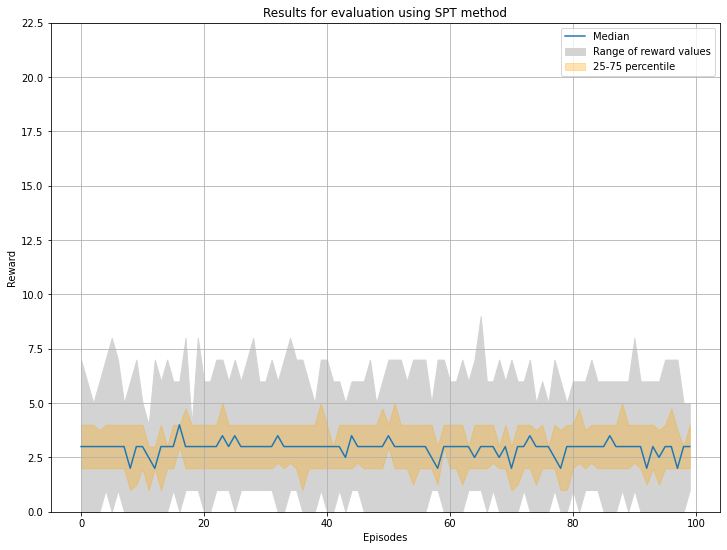

In [17]:
plot_rewards(rewards_all_spt, "SPT")

In [42]:
# FIFO
rewards_all_fifo = []
times_fifo = []
for i in range(30):
    rewards, time_ = test_method("fifo", simulation, no_episodes)
    rewards_all_fifo.append(rewards)
    times_fifo.append(time_)

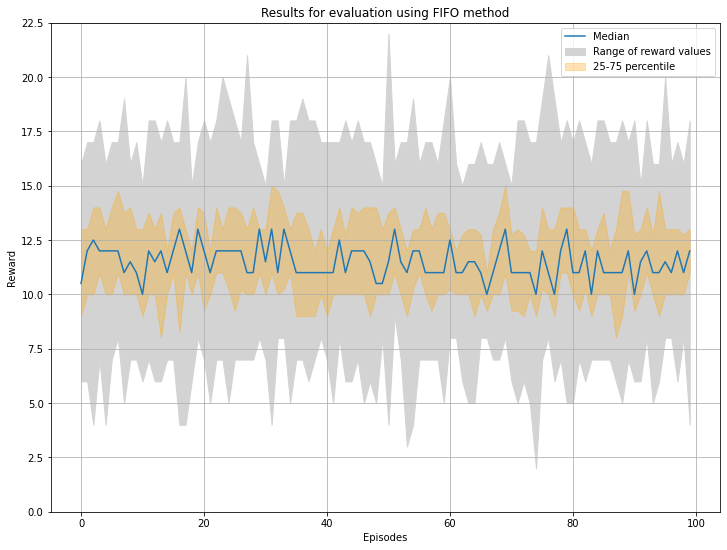

In [43]:
plot_rewards(rewards_all_fifo, "FIFO")

In [15]:
# SPT for steps per episode 3000
# times may very depending on the machine and other process running at the same time on the CPU
rewards_spt_3000, times_spt_3000 = test_method("spt", simulation, no_episodes, steps_per_episode=3000)
print(f"Done with SPT after {times_spt_3000}")
rewards_fifo_3000, times_fifo_3000 = test_method("fifo", simulation, no_episodes, steps_per_episode=3000)
print(f"Done with FIFO after {times_fifo_3000}")

Done with SPT after 2252.8949580192566
Done with FIFO after 1539.9098653793335


In [23]:
path = 'results_recreation_3000/results_20240103_14_17/'
json_path = os.path.join(path, 'report.txt')
with open(json_path, 'r') as f:
    data = json.load(f)
    last_avg_rewards = data['test_last_model_rewards']
    best_avg_rewards = data['test_rewards']
    train_rewards = data['train_rewards']
    train_loss = data['train_loss']

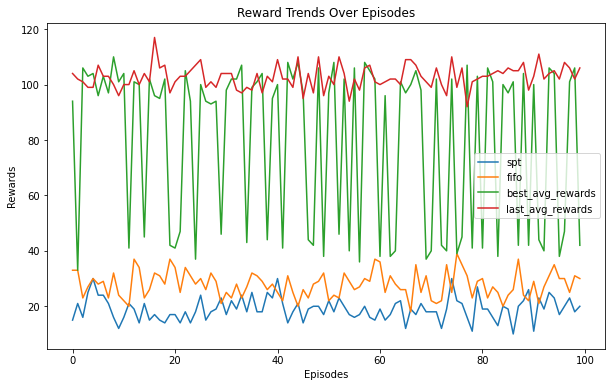

In [24]:
rewards_algos_3000 = {
    "spt":rewards_spt_3000,
    "fifo":rewards_fifo_3000,
    "best_avg_rewards":best_avg_rewards,
    "last_avg_rewards":last_avg_rewards
}

episodes = list(range(len(list(rewards_algos_3000.values())[0])))

plt.figure(figsize=(10, 6))

# Plotting lines for each set of rewards
for key, rewards in rewards_algos_3000.items():
    plt.plot(episodes, rewards, label=f'{key}')

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Reward Trends Over Episodes')

# Adding legend
plt.legend()

# Display the plot
plt.show()

### Paper extension (running example) - baseline

In [17]:
loader = ProcessDataLoader("./my_conf/simulation_config.json", "./my_conf/resource_eligibility.json")
processes = loader.load_process_data()
available_resources = loader.load_available_resources()
process_case_probability = loader.load_process_case_probability()
queue_duration_limit = loader.load_queue_capacity_modifier()
simulation = Simulation(available_resources, processes, process_case_probability, 1, queue_duration_limit, "a10")
no_episodes = 100

In [9]:
# SPT my config
rewards_all_spt = []
times_spt = []
for i in tqdm(range(30), desc="SPT iteration"):
    rewards, time_ = test_method("spt", simulation, no_episodes)
    rewards_all_spt.append(rewards)
    times_spt.append(time_)

SPT iteration: 100%|██████████| 30/30 [36:20<00:00, 72.69s/it]


median 3.0


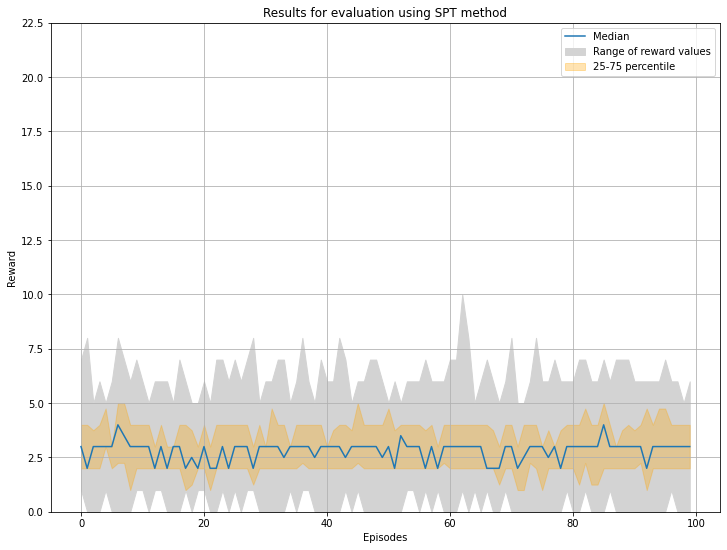

In [10]:
plot_rewards(rewards_all_spt, "SPT")

In [11]:
# FIFO
rewards_all_fifo = []
times_fifo = []
for i in range(30):
    rewards, time_ = test_method("fifo", simulation, no_episodes)
    rewards_all_fifo.append(rewards)
    times_fifo.append(time_)

median 4.0


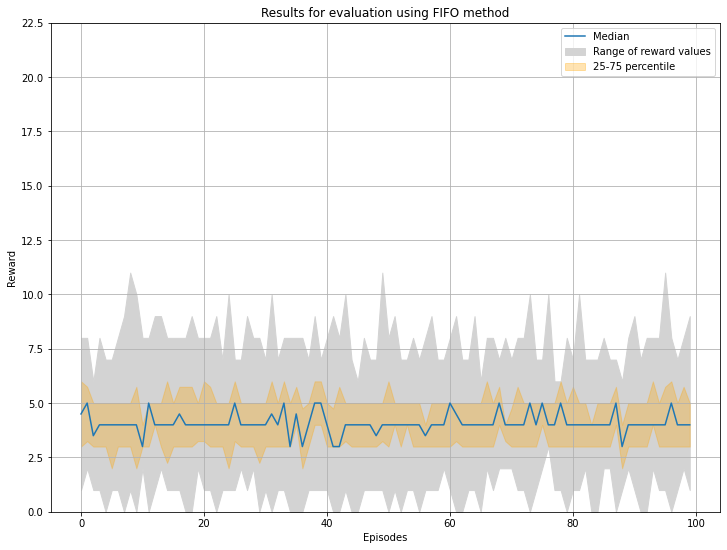

In [14]:
plot_rewards(rewards_all_fifo, "FIFO")

In [18]:
# SPT for steps per episode 3000
rewards_spt_3000_my_conf, times_spt_3000_my_conf = test_method("spt", simulation, no_episodes, steps_per_episode=3000)
print(f"Done with SPT after {times_spt_3000_my_conf}")
rewards_fifo_3000_my_conf, times_fifo_3000_my_conf = test_method("fifo", simulation, no_episodes, steps_per_episode=3000)
print(f"Done with FIFO after {times_fifo_3000_my_conf}")

Done with SPT after 1410.6549263000488
Done with FIFO after 1264.7541961669922


In [26]:
path = 'results_extension_3000/results_20240103_14_52/'
json_path = os.path.join(path, 'report.txt')
with open(json_path, 'r') as f:
    data = json.load(f)
    last_avg_rewards = data['test_last_model_rewards']
    best_avg_rewards = data['test_rewards']
    train_rewards = data['train_rewards']
    train_loss = data['train_loss']

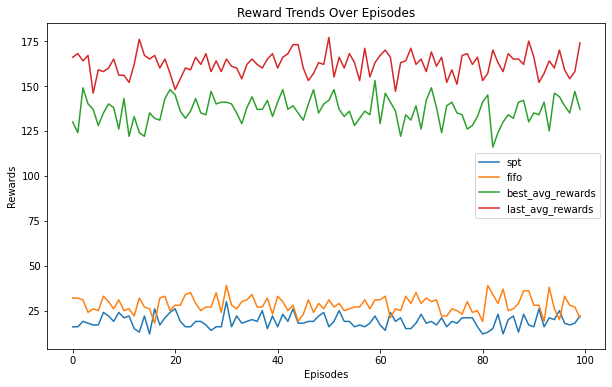

In [27]:
rewards_algos_3000_my_conf = {
    "spt":rewards_spt_3000_my_conf,
    "fifo":rewards_fifo_3000_my_conf,
    "best_avg_rewards":best_avg_rewards,
    "last_avg_rewards":last_avg_rewards
}

episodes = list(range(len(list(rewards_algos_3000_my_conf.values())[0])))

plt.figure(figsize=(10, 6))

# Plotting lines for each set of rewards
for key, rewards in rewards_algos_3000_my_conf.items():
    plt.plot(episodes, rewards, label=f'{key}')

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Reward Trends Over Episodes')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [29]:
print("Average SPT reward:", sum(rewards_spt_3000_my_conf) / len(rewards_spt_3000_my_conf))
print("Average FIFO reward:", sum(rewards_fifo_3000_my_conf) / len(rewards_fifo_3000_my_conf))

Average SPT reward: 19.02
Average FIFO reward: 28.23
